# Assessment 4: Spatial Data Science: Data input, manipulation, analysis and presentation


## Methods implemented: Moran's I, Kriging and DBSCAN

### Introduction:
A shape file is is a simple, nontopological format for storing the geometric location and attribute information of geographic features.
A GeoPackage is an open, non-proprietary, platform-independent and standards-based data format for geographic information system implemented as a SQLite database container.
In this assessment, three statistical methods are used for the analysis of accident distribution caused by senior drivers. 
Namely, Moran's I, Kriging and DBSCAN.

In this project, an external module of assessment4.py is used to store all the methods implemented.
Please refer to assessment4.py for in-depth method execution.


<!-- ### Assumptions/ Declarations:
1. For this project shapefiles of VicRoadsAccidents 2013 -2018 (6 files), LGA_2017_VIC, Regions_SA2016 are used.
2. The dem conversion is done from EPSG:3857 to EPSG:4283 which is vic region, with units in meters.
3. Since the base-input file operated in this program remains constant, it is declared as a constant.
4. Queen's Weight is used for Moran's I weighting.
5. In Kriging interpolation, gaussian variogram model and 40 lags are employed after heuristic approach. 
6. In DBSCAN, 0.5m radius distance tolerance and minimum sample number 5 were decided heuristically.

### Imports
1.  geopandas - for geodataframe manipulation and spatial join
2.  numpy - for array handling in error bars / Kriging
3.  assessment4 - python file containing supporting functions for this project
4.  matplotlib- for plotting custom histograms, lineplot, map visualisation
5.  pyproj  - used for conversion of EPSG in task 2
6.  fiona   - for layer handling of geopackage
7.  seaborn - used for colour palette for cmap
8.  geoplot - for choropleth map visualisation
9.  IPython - used for table handling
10. sklearn - used for DBSCAN processing
11. pysal   - for Moran's I processing (weight, Moran's global / local analysis
12. shapely - for DBSCAN point data handling
13. pykrige - for heatmap analysis
14. timeit - for tracking running time of methods
15. warning - to suppress warnings


### Notes:
1. Choropleth do not have axes since they already represent a map.
2. Markers of barplot are changed depending on the years 
3. Choropleth maps are visualised in both normalised values and absolute numbers for clarity
4. Result of Global and Local Moran's plot, p-value and statistical value are visualised
   to clarify statistical significance
5. Result of Kriging and DBSCAN are overlapped to facilitate the comparison between
   the clustering pattern (density) and severity of accidents
6. Since this file is a report similar to a paper for comparing outputs and data representation, it lacks
   exact code implementations. They are included in assessment4.py
7. In this project, the vehicle is considered for Motocycle, Public vehicle, Passenger Vehicle and Heavy vehicle.  -->


In [186]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib import colors, cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch, Patch
import geoplot as gplt
from matplotlib.lines import Line2D
from geoplot import crs as gcrs
from IPython.display import display, HTML
import assessment4 as worker
import timeit
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pysal as ps
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import libpysal as lp
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import warnings
from pathlib import Path
import analysis as als
from ProjectModules import PrettyTable as pt

%matplotlib inline


OUTPUT_DIR= 'OUTPUT/'

<!-- '''
## Functions 
Primarily contains display functions for plotting bargraph, lineplot and choropleth maps.
''' -->

In [187]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for positive
    strings, green for negative, black otherwise.
    """
    if val>0:
        color='red'
    elif val<0:
        color='green'
    else:
        color='black'
    
    return 'color: %s' % color

In [188]:
def generate_lineplot(data_frame):
    """
    function for visualising line plot. The iterative code to randomise the line markers
    :param data_frame: table to be visualised
    """
    
    marker_list=[i for i,_ in Line2D.markers.items()][4:17]
    fig, axrgb = plt.subplots(1,1, figsize=(10,5))
    j=0
    for i,data in data_frame.iteritems():
        axrgb.plot(data_frame.index.values,data.values,ls='-',marker=marker_list[j],label=data.name)
        j+=1
        if (len(marker_list[j])-1)>j:
                j=0
    fig.suptitle('The rate of change of different severities from 2013 to 2018')            
    plt.xlabel("Years")       
    plt.ylabel("No. of accidents")     
    plt.legend(loc="upper right",title="Severity")
    plt.savefig( Path(OUTPUT_DIR+'severity_transition_13_18.png'), dpi=300, format='png', bbox_inches='tight')

In [189]:
def autolabel(ax,rects,std_dev):
    """
    Support function for barplot:
    Attach a text label/data labels above each bar, 
    displaying its height.
    """
    i=0
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
          xy=(rect.get_x() + rect.get_width() / 2, height+std_dev[i]),
          xytext=(0, 3),  
          textcoords="offset points",
          ha='center', va='bottom')
        i+=1

In [190]:
def generate_barplot(table_name, std_dev):
    """
    function for visualising bar plot of weekly accident.
    :param table_name: table to be visualised
    :param std_dev: array of error bar values
    """

    data_2013 = table_name['2013'].values
    data_2018 = table_name['2018'].values
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    labels=table_name.index.values
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    rects1 = ax.bar(x - width / 2, data_2013, width, label='2013',yerr=std_dev)
    rects2 = ax.bar(x + width / 2, data_2018, width, label='2018',yerr=std_dev)
    ax.set_ylabel('No. of accidents')
    ax.set_title('Comparison of accidents between 2013 and 2018 by weekdays')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(title='Years')
    autolabel(ax,rects1,std_dev)
    autolabel(ax,rects2,std_dev)
    fig.tight_layout()
    plt.savefig(Path(OUTPUT_DIR+'weekly_accident_13_18.png'), dpi=300, format='png', bbox_inches='tight')
    plt.show()

In [191]:
def generate_choropleth(data_frame,initial_year,final_year,title):
    """
    function plots the data frame in heatmap format. 
    Default coloring is used to highlight the best colors.
    """
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
    data_frame.plot(column=initial_year,
             ax=ax1,
               legend=True,
               legend_kwds={'label': "Most Severe Accident: '\n' Other injury accident",
                            'orientation': "horizontal"})
    data_frame.plot(column=final_year,
             ax=ax2,
               legend=True,
               legend_kwds={'label': "Most Severe Accident: '\n' Other injury accident",
                            'orientation': "horizontal"})
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title(initial_year+':Data plotting') 
    ax2.set_title(final_year+' :Data plotting')
    fig.suptitle(title)
    plt.savefig(Path(OUTPUT_DIR+'choropleth_chart_2013_2018.png'), dpi=300, format='png', bbox_inches='tight')

#### Task 1:
Firstly, all the accident point shapefiles of different years were concatonated to one file.
Then, year value is extracted from accident date column to be appended to the all year geodataframe.
Followingly, to get the LGA name column for merged area, spatial join was conducted
for task 1.2 data preparation,and vice versa was performed for visualisation of task 1.3.c
after the conversion of CRS of accident file to 4283, CRS of LGA_17 shapefile.
Table manipulation for task 1.2 was conducted using pandas / geopandas dataframe manipulation.

In [192]:
"""
Create ouput directory if not present
"""
if not Path(OUTPUT_DIR).is_dir():
    os.mkdir(OUTPUT_DIR)

In [193]:
accident_list=worker.load_shape_files()

In [194]:
merged_data=worker.merge_shape_files(accident_list)

In [195]:
# The shape files have mixed no of accident dates. Thus we filter them again to get the no.s accurate
total_data=worker.add_year_column(merged_data)

#####  Task 1.1
The average number of accidents is produced counting the accident number of the dataframe 
where all the accident point are concatonated.
Top 2 accident counts and percentages are calculated counting the accident number 
after creating a dataframe grouped by accident type, and dividing each values by the total accident count.

The most common type of accident is collision with vehicle, exceeding more than the half of all the accidents
and collision with the objects marked approximately 16 % of all accidents.

In [196]:
avg_per_year=worker.extract_avg_accidents(total_data)
print('The average number of accidents per year is {}.'.format(avg_per_year))

The average number of accidents per year is 12212.


In [197]:
#task 1.b
acc_count=worker.calc_accident_percent(total_data)

In [198]:
print('The most common type of accident in all the recorded years is {} (equal to {}% accidents), and the second most common is {} ({}%).'.format(acc_count[0][0],acc_count[0][1],acc_count[1][0],acc_count[1][1]))

The most common type of accident in all the recorded years is 46147 (equal to 63.0% accidents), and the second most common is 11557 (15.8%).


##### Task 1.2
1. Task 1.2.a Table is created grouping table by years column and displaying vehicle type columns.
2. Task 1.2.b Table is created manipulation of three tables created (Absolute number, difference and change)
after grouping by and filteringof spatial joined data ofmerged accident points geodataframe and that of LGA.

In vehicle types involved in the accidents, passenger vehicle excelled all other types and showed the number jumped up
to two times from 2013 to 2014, preserving its level until 2016.
In 2013 top 10 regions, this abrupt change of accidents are observed from 2013 to 2014, and following years marked
generally lowering tendency in accident numbers.

In [199]:
vehicle_distn=worker.find_vehicle_distn(total_data)
vehicle_distn=vehicle_distn.transpose()
# display(worker.format_fordisplay(vehicle_distn))

a_list=['Year']+(list(worker.format_fordisplay(vehicle_distn).columns.values)) 
vehicle_dlist=[[ r'$'+x+'$' for x in a_list]]
temp=[]
for i,data in vehicle_distn.iterrows():
      temp.append(i)
      vehicle_dlist.append(temp+list(data.values))
      temp=[]

pt.PrettyTable(vehicle_dlist)

$Year$,$2013$,$2014$,$2015$,$2016$,$2017$,$2018$
No of Vehicles,12237,25585,26043,25898,22290,20210
Heavy Vehicles,315,599,705,615,587,539
Passenger Vehicles,9678,20136,20476,20731,17518,15743
Motorcycle,995,2194,2204,2216,1847,1704
Public Vehicle,92,172,210,153,148,159


The data cleaned for 'locations' by using point and polygon/Muiltipolygon in the LGA and the total data since geometry will be used henceforth for calculations.

In [200]:
lga_df = worker.read_LGA()
lga_df = worker.clean_lga_df(lga_df)
total_data=worker.clean_total_data(total_data)


We can see that highlighted red cells are the lgas where the accidents have increased from the previous year, whereas the the green indicates decrease in accident rates. 

In [201]:
total_data = worker.reproject(total_data,lga_df.crs)
acc_bylga=worker.calc_accidents_bylga(total_data,lga_df)

In [241]:


indexes=[]
for x in acc_bylga.columns:
     if x[1]=='Change':
         indexes.append(x)   
visual_table=acc_bylga.style.applymap(color_negative_red, 
                             subset=pd.IndexSlice[:, indexes]).format('{:.2f}')


In [242]:
acc_bylga

,LGA_NAME17,2013 No.,2014 No.,2014 Diff.,2014 Change,2015 No.,2015 Diff.,2015 Change,2016 No.,2016 Diff.,2016 Change,2017 No.,2017 Diff.,2017 Change,2018 No.,2018 Diff.,2018 Change,geometry
0,Melbourne (C),390.0,797.0,407.0,1.04,817.0,20.0,0.03,697.0,-120.0,-0.15,660.0,-37.0,-0.05,600.0,-60.0,-0.09,"POLYGON ((144.96941 -37.83045, 144.96830 -37.8..."
1,Greater Geelong (C),248.0,507.0,259.0,1.04,482.0,-25.0,-0.05,531.0,49.0,0.10,498.0,-33.0,-0.06,442.0,-56.0,-0.11,"POLYGON ((144.35076 -38.25054, 144.34547 -38.2..."
2,Brimbank (C),245.0,463.0,218.0,0.89,438.0,-25.0,-0.05,430.0,-8.0,-0.02,346.0,-84.0,-0.20,344.0,-2.0,-0.01,"POLYGON ((144.83811 -37.70933, 144.84260 -37.7..."
3,Casey (C),240.0,522.0,282.0,1.17,582.0,60.0,0.11,610.0,28.0,0.05,490.0,-120.0,-0.20,456.0,-34.0,-0.07,"POLYGON ((145.31700 -37.96784, 145.31712 -37.9..."
4,Greater Dandenong (C),226.0,467.0,241.0,1.07,502.0,35.0,0.07,519.0,17.0,0.03,394.0,-125.0,-0.24,353.0,-41.0,-0.10,"POLYGON ((145.18166 -38.07055, 145.16814 -38.0..."
5,Monash (C),226.0,465.0,239.0,1.06,466.0,1.0,0.00,422.0,-44.0,-0.09,362.0,-60.0,-0.14,313.0,-49.0,-0.14,"POLYGON ((145.18750 -37.93699, 145.18660 -37.9..."
6,Hume (C),204.0,452.0,248.0,1.22,453.0,1.0,0.00,485.0,32.0,0.07,384.0,-101.0,-0.21,395.0,11.0,0.03,"POLYGON ((144.95001 -37.51127, 144.95029 -37.5..."
7,Yarra Ranges (S),192.0,436.0,244.0,1.27,465.0,29.0,0.07,434.0,-31.0,-0.07,377.0,-57.0,-0.13,290.0,-87.0,-0.23,"POLYGON ((145.36099 -37.97205, 145.35796 -37.9..."
8,Moreland (C),190.0,397.0,207.0,1.09,415.0,18.0,0.05,390.0,-25.0,-0.06,347.0,-43.0,-0.11,342.0,-5.0,-0.01,"POLYGON ((144.97948 -37.69984, 144.97945 -37.6..."
9,Kingston (C) (Vic.),183.0,362.0,179.0,0.98,347.0,-15.0,-0.04,324.0,-23.0,-0.07,296.0,-28.0,-0.09,270.0,-26.0,-0.09,"POLYGON ((145.13788 -37.95284, 145.13774 -37.9..."


In [243]:
## incase it doesnt render in pdf report fall back option

# display_frame=acc_bylga
# list_column_names=list(display_frame.columns)
# new_txt=''
# for i,name in enumerate(list_column_names):
#     if type(name)==tuple:
#         new_txt=name[0]+' '+name[1]
#         list_column_names[i]=new_txt
# display_frame.columns=list_column_names
# display_frame.transpose()
# a_list=(list(worker.format_fordisplay(display_frame).columns.values)) 

# value_list=[[ r'$'+x+'$' for x in a_list]]

# for li in display_frame.values.tolist():
#     value_list.append(li)
# pt.PrettyTable(value_list)

##### Task 1.3

For the preparation of datasets to be visualised for task 1.3 a and b, the all-year accident point datasets are
groped by year and day of week (1.3.a), severity (1.3.b) and then accident number is counted. For task 1.3.c,
spatial join was conducted merging all year accident point datasets to LGA data, to get the polygon geometry for
choropleth map visualisation.

Barplot and lineplots are visualised following the exmples of the assignment brief images.
Choropleth maps are visualised according to the values, in absolute values and normalised values.

In the barplot,all seven days showed higher values than those of 2013. In 2013, all the days except Sunday showed almost same values. On the other hand, weekdays showed a higher accident occurence than weekends.

In terms of severity of the accident, other injury accident superceded other three types. Serious injury accident marked almost half to one-third of the accident occurence of other accidents. Both other injury and serious injuries increased abruptly, but after 2016 both of them decreased in number. Fatal accident remains low. Non injury accident only occured once in 2015.

In normalised version of choropleth maps of LGA indicate that overall tendency remains the same,
but the north-west and north-east parts of Victoria showed difference in the occurence of other type of accident.
However, the choropleth maps of absolute numbers shows almost no change in terms of difference in 2013 and 2018.

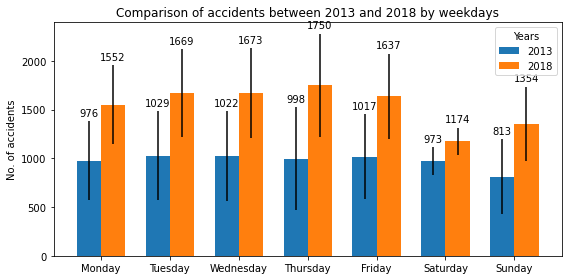

In [204]:
acc_weekly = worker.calc_accidents_byweek(total_data)
std_error_acc = acc_weekly.T.std().values
generate_barplot(acc_weekly, std_error_acc)

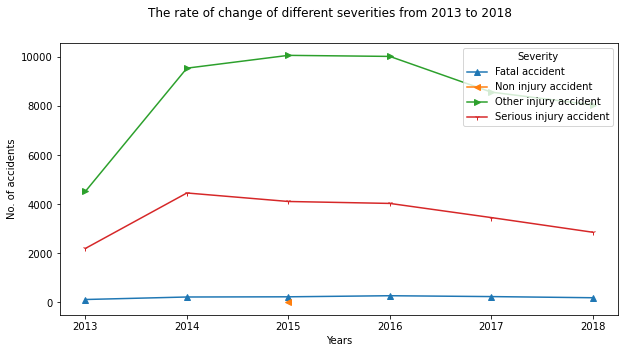

In [205]:
# Task 1.3 b
acc_severity=worker.calc_accidents_byservity(total_data)
generate_lineplot(acc_severity)

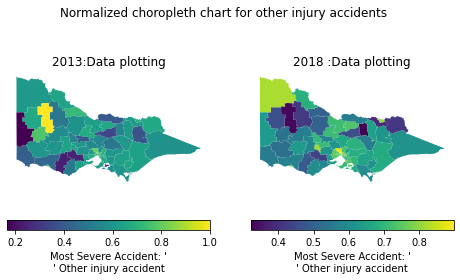

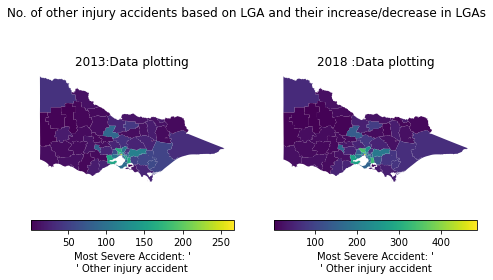

In [206]:
# task 1.3 c
acc_lga = worker.get_acc_lga(total_data,lga_df)
title='Normalized choropleth chart for other injury accidents'
generate_choropleth(worker.get_normalized_data_choro(acc_lga,lga_df),'2013','2018',title)
title='No. of other injury accidents based on LGA and their increase/decrease in LGAs'
generate_choropleth(worker.get_data_choro(acc_lga,lga_df),'2013','2018',title)


#### Task 2

##### Task 2.1
1. Addition of data from vehicle distribution. The dataframe is transposed so that geometry can be added into it. Since the vehicle distribution dataframe didnt have a geometry or crs, the required data is added into it. The geometry is taken from the total_dataset from which we computed the vehicle distribution and 'dissolved' by finding mean of the geometries. 
2. The accidents by LGA dataframe (table) is added after LGA region geometry is merged into it. The column names of LGA table need to readjusted so that it can be added into the geodataframe.

In [207]:
vehicle_distn=vehicle_distn.transpose()
vehicle_distn_gdf = worker.generate_gdf(vehicle_distn,total_data)
vehicle_distn_gdf.to_file("assessment4.gpkg", layer='AccidentsByYear', driver="GPKG")

In [208]:
"""
convert the tuple column headers into a list
"""
list_column_names=list(acc_bylga.columns)
new_txt=''
for i,name in enumerate(list_column_names):
    if type(name)==tuple:
        new_txt=name[0]+' '+name[1]
        list_column_names[i]=new_txt
acc_bylga.columns=list_column_names
acc_bylga=gpd.GeoDataFrame(acc_bylga.merge(gpd.GeoDataFrame(lga_df['LGA_NAME17'],geometry=lga_df.geometry), on='LGA_NAME17'),crs=lga_df.crs)


In [209]:
acc_bylga.to_file("assessment4.gpkg", layer='AccidentsByLGA', driver="GPKG")


##### Task 2.2: Get the accident locations layer based on requirements
Accident Locations are indentified with 3 or more people involved and some of the information is collected, such as Accident no, Vehicle type (Passenger, Public, Motorcycle, Heavy vehicle), Day of week, Num of people involved and the severity.

In [210]:
filtered_data=worker.filter_3people(total_data)
acc_locations=worker.add_accident_locations(filtered_data)

##### Task 2.3 : Add SA2 region data to accident Location
Sjoin function uses Rtree under the hood, therefore a test is run check the performance difference while completing a join iteratively or naively. Firstly, the sa2 region dataset is cleaned for joining.
The naive way of joining was implemented which took 2273.8 seconds of time to complete the join,
where as sjoin which uses Rtree completed with 1.6 secs

In [211]:
sa2=worker.read_SA2()
sa2=worker.clean_lga_df(sa2)
sa2=worker.reproject(sa2,filtered_data.crs)

In [212]:
# """
# Please note the following method is disabled for computational speed of the entire notebook. 
# For test purposes please enable it.
# """
# starttime = timeit.default_timer()
# worker.add_SA2_naive_method(acc_locations,sa2)
# print("The time taken is :", timeit.default_timer() - starttime)

In [213]:
starttime = timeit.default_timer()
sp_index_join=worker.spatial_index_join(acc_locations,sa2)
# print("The time taken is :", timeit.default_timer() - starttime) The time taken is : 2.75417920000109
sp_index_join.to_file("assessment4.gpkg",layer="AccidentLocations")


##### Task 2.4 : Get accident locations based on the days of the week
The accidents are data is further divided into based on day of the week,i.e weekend or weekday. The exported geopackage can be opened to check validity and the result of the computation.

In [214]:
acc_locations = gpd.read_file("assessment4.gpkg",layer='AccidentLocations')

(acc_byweekends,acc_byweekdays)= worker.divide_accidents(acc_locations)
acc_byweekends.to_file("assessment4.gpkg",layer='SevereAccidentsWeekend')
acc_byweekdays.to_file("assessment4.gpkg",layer='SevereAccidentsWeekday')

##### Task 3 : Spatial Data analysis using the given dataset 

##### Motivation
In recent years, along with senior population increase in Australia due to the rise of the average life expetancy, severe accidents caused by the elders is increasing [1]. In Victoria, elderly population is in increase in the regional areas [2]. In this part, the geospatial distribution of accident locations caused by senior citizens and areas potentially susceptive to the car accidents by elderly population will be identified.

##### Methods
This analysis will be conducted by using three statistical methods. Firstly, Moran's I will be implemented identify the areas of LGA where its areal adjacency pattern with their neighbours is statistically significant (the areal surrounding pattern is not randomly produced). In this analysis, the regions with high accident occurence surrounded by those with low accident occurence were selected as these can be the areas peculiar enough to have special attention. Followingly, heatmap of the identified regions by Moran's I will be drawn utilising Kriging method focuing on the accident severity (number of fatality and injury) throughout the identified regions. Then, spatial distribution of density of accidents will be identified conducting DBSCAN analysis over the same area. Finally, combining the heatmap and density map, distribution of accident severity and density of accident occurence will be compared visually if they spatially coincide.

In [215]:
#Data preparation
LGA=worker.read_LGA()

LGA_clean = worker.clean_lga_df(LGA)

# Spatial left join LGA + Accident
total_data = worker.add_year_column(merged_data)
total_data= worker.reproject(total_data,LGA_clean.crs)
acc_LGA = worker.get_acc_lga(total_data,LGA_clean)
# Extract the top accident type per area in 2013
acc_2013_type = acc_LGA[acc_LGA['year'] == '2013'].groupby(['LGA_NAME17','ACCIDENT_1'])['ACCIDENT_N'].count().sort_values(ascending=False)
top_2013 = acc_2013_type.unstack(level=0).idxmax().to_frame().reset_index().rename({0:'type2013'}, axis=1)

# Extract the top accident type per area in 2018
acc_2018_type = acc_LGA[acc_LGA['year'] == '2018'].groupby(['LGA_NAME17','ACCIDENT_1'])['ACCIDENT_N'].count().sort_values(ascending=False)
top_2018 = acc_2018_type.unstack(level=0).idxmax().to_frame().reset_index().rename({0:'type2018'}, axis=1)

# Join 2013 / 2018 top accident types to LGA features
LGA_top13 = LGA.merge(top_2013, on='LGA_NAME17')
LGA_top1318 = LGA_top13.merge(top_2018, on='LGA_NAME17')


In [216]:
acc_old,LGA_old_each =als.accident_region(acc_LGA,LGA)


In [217]:
# Extract the lon / lat for later process
acc_old_analysis=als.add_long_lat(acc_LGA)

# acc_old_analysis.head(2)

#### 1. Moran's I autocorrelation analysis
In this analysis, we will identify the areas with high number of accidents surrounded by areas with low number accidents. Firstly, Global Autocorrelation is tested to verify its statistical significance with p-value and the value of statistics that indicates the positive / negative / no correlation among regions globally (positive = areas with similar values are prevelent / negative = different values are prevalent / no (0) correlation = spatial pattern is completely random). After verifying the values, local Moran's I will be conducted for the patterns surrounding each region with statistic significance (HH: region with high accident volume surrounded by high volume regions, HL: high volume regions surrounded by low volume regions, LH: low volume region with high volume regions, LL: low volume region with low volume regions). The result will be visualised in a figure and HL areas identified will be studied in heatmap and density analysis.

In [218]:
LGA_old_each=als.calc_LGA_old_each(acc_LGA,LGA)

    # LGA_old_each

In [219]:
# Create weights for analysis - queens weight is employed as it is the most common method []
LGA_old_each,w= als.append_weight_lga_old(LGA_old_each)


#### Figure. 1 Global Moran's Plot

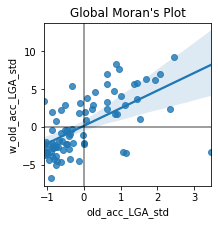

<Figure size 432x288 with 0 Axes>

In [244]:
# Global Autocorrelation

# Moran plot
# Setup the figure and axis

f, ax = plt.subplots(1, figsize=(3, 3))
# Plot values
sns.regplot(x='old_acc_LGA_std', y='w_old_acc_LGA_std', data=LGA_old_each)
# Add vertical and horizontal lines
plt.title("Global Moran's Plot")
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display and print figure in png
plt.show()
plt.savefig(Path(OUTPUT_DIR+"Global_Moran_Plot.png"), dpi=300, format='png', bbox_inches='tight');

#### Moran's I statistic value and p-value

In [221]:
#Moran's I
mi = ps.explore.esda.moran.Moran(LGA_old_each['old_acc_LGA_std'], w)

#Statistic value / P-value of Moran's I
print('The statistic value is {} and p-value is {}.'.format(mi.I.round(2), mi.p_sim))

The statistic value is 0.42 and p-value is 0.001.


#### Figure. 2 Local Moran's Plot

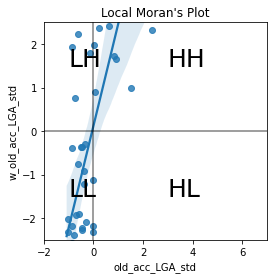

<Figure size 432x288 with 0 Axes>

In [246]:
#Local spatial autocorrelation
# Four groups derived from the Moran Plot: 
# high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL),
# and viceversa (LH). Each of these groups are typically called "quadrants"

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(4, 4))
# Plot values
sns.regplot(x='old_acc_LGA_std', y='w_old_acc_LGA_std', data=LGA_old_each)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-2, 7)
ax.set_ylim(-2.5, 2.5)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)
# Add title
plt.title("Local Moran's Plot")

# Display
plt.show()
plt.savefig(Path(OUTPUT_DIR+"Local_Moran_Plot.png"), dpi=300, format='png', bbox_inches='tight');

In [223]:
#LISA (Local indicators of spatial information: https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1995.tb00338.x)
lisa = ps.explore.esda.moran.Moran_Local(LGA_old_each['old_acc_LGA_std'].values, w)

In [224]:
# Break observations into significant or not
LGA_old_each['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
LGA_old_each['quadrant'] = lisa.q
# LGA_old_each

#### Figure.3  Regional driver accident pattern

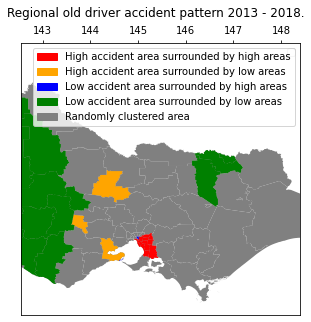

<Figure size 432x288 with 0 Axes>

In [225]:
#Visualise the concentration

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(5,5))
ax2 = ax.twiny()

#LGA as Basemap (Grey - random area)
LGA_top1318.plot(ax=ax2, color='grey')

# Plot HH clusters
hh = LGA_old_each.loc[(LGA_old_each['quadrant']==1) & (LGA_old_each['significant']==True), 'geometry']
gpd.plotting.plot_series(hh, ax=ax2,  color='red', markersize=5)
# Plot HL clusters
hl = LGA_old_each.loc[(LGA_old_each['quadrant']==4) & (LGA_old_each['significant']==True), 'geometry']
gpd.plotting.plot_series(hl, ax=ax2, color='orange', markersize=5)
# Plot LH clusters
lh = LGA_old_each.loc[(LGA_old_each['quadrant']==2) & (LGA_old_each['significant']==True), 'geometry']
gpd.plotting.plot_series(lh, ax=ax2, color='blue', markersize=5)
# Plot LL clusters
ll = LGA_old_each.loc[(LGA_old_each['quadrant']==3) & (LGA_old_each['significant']==True), 'geometry']
gpd.plotting.plot_series(ll, ax=ax2, color='green', markersize=5)


# Style and draw
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

hh_patch = Patch(color='red', label='High accident area surrounded by high areas')
hl_patch = Patch(color='orange', label='High accident area surrounded by low areas')
lh_patch = Patch(color='blue', label='Low accident area surrounded by high areas')
ll_patch = Patch(color='green', label='Low accident area surrounded by low areas')
rd_patch = Patch(color='grey', label='Randomly clustered area')
plt.legend(handles=[hh_patch, hl_patch, lh_patch, ll_patch, rd_patch])

f.suptitle('Regional old driver accident pattern 2013 - 2018.')
ax.set_axis_off()
plt.axis('equal')

#Plot and print the figure
plt.show()
plt.savefig(Path(OUTPUT_DIR+'regional_old_driver_accident_pattern.png'), dpi=300, format='png', bbox_inches='tight');

In [226]:
# Identify areas with high accident no. surrounded by low accident areas
unusual_area = LGA_old_each.loc[(LGA_old_each['quadrant']==4) & (LGA_old_each['significant']==True), 'LGA_NAME17']

# Limit the area to the unusual areas identified fpr later analysis
acc_old_analysis_LGA = acc_old_analysis[acc_old_analysis['LGA_NAME17'].isin(unusual_area.values.tolist())]

# Print out the unusual area identified
print('The area unusually concentrated in accidents by elderly people outside of Greater Melbourne is {}.'.format(unusual_area.values.tolist()))

The area unusually concentrated in accidents by elderly people outside of Greater Melbourne is ['Ballarat (C)', 'Greater Bendigo (C)', 'Greater Geelong (C)'].


#### 2. Heatmap analysis (Kriging)
In this analysis, the area identified by Moran's I analysis will be studied utilising Kriging method. The z values (to be examined its spatial pattern) is the number of casualities involved in the accidents. The result will be combined with the result of the DBSCAN analysis in the following section.

In [227]:
# Extract lon lat min for later visualisation
xmax = max(acc_old_analysis_LGA["lon"])
ymax = max(acc_old_analysis_LGA["lat"])
xmin = min(acc_old_analysis_LGA["lon"])
ymin = min(acc_old_analysis_LGA["lat"])

In [228]:
# Assign lon / lat to array to assign for Ordinary Kriging Head is used to limit the samples as memory constraint exists
lons=np.array(acc_old_analysis_LGA['lon']) 
lats=np.array(acc_old_analysis_LGA['lat']) 
data=np.array(acc_old_analysis_LGA['INJ_OR_FAT']) 

#Create grid points where values are interpolated
grid_space = 0.01 # grid_space: desired delta/step of the output array
grid_lon = np.arange(np.amin(lons), np.amax(lons), grid_space) 
grid_lat = np.arange(np.amin(lats), np.amax(lats), grid_space)

In [229]:
# Perform ordinary kriging using gaussian variogram model / check the varigoram. Lag is optimised according to xxx
print('Kriging using gaussian variogram model')
OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', verbose=False, enable_plotting=False,nlags=40)

# z1 is the interpolated values of “OLD_DRIVERS” at the grid_lon and grid_lat values.
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

Kriging using gaussian variogram model


#### 3. Cluster Analysis (Density of Accident Points)
#### DBSCAN
Finally, The regional areas identified by Moran's I analysis will be examined utilising DBSCAN method. In this analysis, the distance of cluster is defined 500 metre (0.5 km), and in case that there are more than 5 accident points within this radius, it will be classified as the cluster.

In [230]:
num_clusters,clusters=als.find_clusters(acc_old_analysis_LGA)
# Check number of clusters
print('Number of clusters: {}'.format(num_clusters-1))

Number of clusters: 18


In [231]:
# Extract lon lat for Geelong area to create bounds for density visualisation
xmaxG = max(acc_old_analysis_LGA["lon"])
ymaxG = max(acc_old_analysis_LGA["lat"])
xminG = min(acc_old_analysis_LGA["lon"])
yminG = min(acc_old_analysis_LGA["lat"])


In [232]:
def get_centermost_point(cluster):
    """
    This function is to extract the centroids of clusters.
    param cluster: pandas.Series of clusters
    return: tuple of the centroids of clusters
    """
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [233]:

centermost_points = clusters.map(get_centermost_point)

In [234]:
# Get lon and lats to Dataframe for visualisation
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [235]:
# Points represented as the center of distribution (Closest to the centroid of accident cluster)
rs = rep_points.apply(lambda row: acc_old_analysis_LGA[(acc_old_analysis_LGA['lat']==row['lat']) & (acc_old_analysis_LGA['lon']==row['lon'])].iloc[0], axis=1)


#### Figure. 4 concentration of the accidents and severity heatmap of old driver accidents

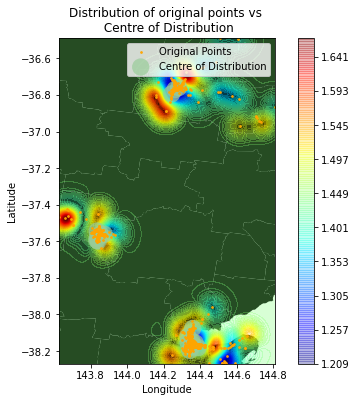

<Figure size 432x288 with 0 Axes>

In [248]:
#Visualise the Final Result
fig, ax = plt.subplots(figsize=(8,6))

#basemap - LGA
LGA_top1318.plot(ax=ax, color='black')

#Grid the values of Kriging result to be interpolated
xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)

#Limit the area
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

#Kriging result
contour = plt.contourf(xintrp, yintrp, z1,len(z1),cmap=plt.cm.jet,alpha = 0.3)
plt.colorbar(contour)
npts = len(lons)


#Original points and centroids
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=300)
df_scatter = ax.scatter(acc_old_analysis_LGA['lon'], acc_old_analysis_LGA['lat'], c='orange', alpha=0.9, s=3)

#Styling
ax.set_title('Distribution of original points vs \n Centre of Distribution')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Original Points', 'Centre of Distribution'], loc='upper right')

#Plot and print the figure and 
plt.show()
plt.savefig(Path(OUTPUT_DIR+'Distribution of original points vs Centre of Distribution.png'), dpi=300, format='png', bbox_inches='tight')

#### Result and Conclusion

Global Moran's I analysis showed the value around 0.42, indicating that the number of old driver has a positive correlation and p-value showed only 1 %, which suggests that pattern of accidents occurence are similar over the study area and statistically significant. Followingly, local autocorrelation analysis was performed, resulting the area of Bendigo, Ballarat and Geelong are the regions where accidents are occuring with high frequencies being surrounded by low accident regions outside of greater Melbourne. Followingly, DBSCAN analysis identified 18 clusters and the analysis result was combined with the heatmap produced by Kriging interpolation with the z-value of accident casualities involving old drivers. The combined figure suggested that areas of regions where accidents are clustered densely had less casualities, while remote areas where accidents occur less had high casualties. This can be because the areas with high accident occurence are areas possibly urbanised or sightseeing areas where travelling speed is limited and well-obverved, and the number of cars is high, while the remote areas tend to have less cars and eyes observing the speed limit, and highways are existent, which is possibly causing heavier accidents. However, although this information can be informative for the identification of areal accident occurence distribution, these observations should be compared and verified in further study due to the limitation of the analytical tools as well as the method itself. Firstly, Kriging method assumes the isotoropy of the tendency of observed sample values to every direction [3]. As observed in the analysis result, remote areas of this study have small amount of samples, which possibly does not coincide to the actual situation. Secondly, this analysis does not concern temporal distribution pattern of accidents nor areal characteristics such as geographical difference among study areas [4]. Analysis with the accident occurence time column as well as new datasets containing geographical information should be encouraged.

## Reference
[1] ABC North Coast(2018). Fatal crashes involving older drivers rise as surgeon calls for advertising rethink [online] available at: https://www.abc.net.au/news/2018-05-15/older-drivers-in-more-fatal-crashes/9761756 [Accessed June 14 2020]

[2] Australian Bureau of Statistics(2010).POPULATION AGEING IN VICTORIA, State and Regional Indicators, Victoria, vol.1367  [online] available at: https://www.abs.gov.au/AUSSTATS/abs@.nsf/Lookup/1367.2Chapter3Jun+2010 [Accessed June 14 2020]

[3] Statistics How to, Kriging: Definition, Limitations [online] available at:https://www.statisticshowto.com/kriging/#:~:text=Limitations%20of%20Kriging%20Interpolation,change%20throughout%20the%20study%20space [Accessed June 14 2020]

[4] Lutins, E.(2017). DBSCAN: What is it? When to Use it? How to use it. [online] https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818#:~:text=Disadvantages%20of%20DBSCAN%3A,Struggles%20with%20high%20dimensionality%20data [Accessed June 14 2020]
